### Objective:
To enhance flight operational efficiency, safety, and customer satisfaction through data-driven route optimization, real-time monitoring, and predictive analytics.

### Import Libriaries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from geopy.geocoders import Nominatim
from folium import IFrame
from folium.plugins import PolyLineTextPath
from datetime import datetime, timezone, timedelta
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report






pip install folium


pip install plotly


pip install geopy


In [2]:
#create function to wrangle the dataframe
def wrangle(file_path):
    df = pd.read_csv(file_path)
    #splitting the position column in lat and lon column
    df[['lat','lon']] = df['Position'].str.split(',', expand =True).astype(float)
    # dropping the position column
    #rename my Direction column
    df.rename(columns={'Direction': 'Direction(degree)'}, inplace=True)

    df.drop(columns = 'Position', inplace = True)
    #check and drop columns with the high and low cardinality.
    df.drop(columns = 'Callsign', inplace = True)
    #converting Timestamp and utc column to datetimes object
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['UTC'] = pd.to_datetime(df['UTC'])
    
    # Convert the 'Timestamp' column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    # Extract the date part from the 'UTC' column (assuming it's already in datetime format)
    df['UTC_date'] = df['UTC'].dt.date
    # Extract the time part from the 'Timestamp' column and convert it to UTC timezone

    df['Timestamp_UTC'] = df['Timestamp'].dt.time
    # Combine date from 'UTC' column and time from 'Timestamp_UTC' column
    df['Timestamp_UTC'] = pd.to_datetime(df['UTC_date'].astype(str) + ' ' + df['Timestamp_UTC'].astype(str))
    # Drop intermediate columns if not needed anymore
    df.drop(columns=['UTC_date'], inplace=True)
    df.drop(columns=['Timestamp'], inplace=True)
   
    
    return df

In [3]:
#Reading dataframe into memory
df = wrangle('flight.csv')

## Exploring Data

In [4]:
#creating a colunmn distance using haversine
def haversine(lat1, lon1, lat2, lon2):
    
    """ calculates the great-circle distance between two points on the Earth's surface using the Haversine formular."""
    
    R = 6371.0  # Earth's radius in kilometers
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    
    return distance

df['distance'] = haversine(df['lat'], df['lon'], df['lat'].shift(), df['lon'].shift())


In [5]:
 #drop null value in distance column 
df.dropna(subset = 'distance', inplace =True)

In [6]:
#creating a column cardinal_direction
def get_direction(degrees):
     # using the Direction column to create eight cardinal points by
     #takes a standard unit of angular measurement in degrees as input and returns 
     #the corresponding cardinal direction based on the angle 
    
    if 0 <= degrees < 22.5 or degrees >= 337.5:
        return 'North'
    elif 22.5 <= degrees < 67.5:
        return 'North_East'
    elif 67.5 <= degrees < 112.5:
        return 'East'
    elif 112.5 <= degrees < 157.5:
        return 'South_East'
    elif 157.5 <= degrees < 202.5:
        return 'South'
    elif 202.5 <= degrees < 247.5:
        return 'South_West'
    elif 247.5 <= degrees < 292.5:
        return 'West'
    else:
        return 'North_West'

df['cardinal_direction'] = df['Direction(degree)'].apply(get_direction)


In [7]:
#mask = df['cardinal_direction'] =='North'  
#df = df[mask]

In [8]:
#df['year'] = df['Timestamp'].dt.strftime('%Y')

In [9]:
#df['UTC_year'] = df['UTC'].dt.strftime('%Y')

## EDA


In [10]:
#checking for the value count of each cardinal direction
df.cardinal_direction.value_counts()

cardinal_direction
North_West    351
North         105
North_East     88
West           84
South_West     78
South_East     29
East           19
South           6
Name: count, dtype: int64

In [11]:
# set Timestamp_UTC as the index column
df.head().set_index('Timestamp_UTC')

UTC  Altitude  Speed  \
Timestamp_UTC                                                           
2023-01-09 00:00:01.673304 2023-01-09 22:43:25+00:00         0      3   
2023-01-09 00:00:01.673304 2023-01-09 22:43:45+00:00         0      3   
2023-01-09 00:00:01.673304 2023-01-09 22:44:07+00:00         0      1   
2023-01-09 00:00:01.673304 2023-01-09 22:44:41+00:00         0      1   
2023-01-09 00:00:01.673304 2023-01-09 22:45:07+00:00         0      1   

                            Direction(degree)        lat        lon  distance  \
Timestamp_UTC                                                                   
2023-01-09 00:00:01.673304                 39  25.267582  51.605137  0.033274   
2023-01-09 00:00:01.673304                 53  25.267376  51.604946  0.029893   
2023-01-09 00:00:01.673304                 47  25.267284  51.604740  0.023103   
2023-01-09 00:00:01.673304                354  25.267159  51.604538  0.024613   
2023-01-09 00:00:01.673304                334  25.266953  51.604527  0.022933   

                           cardinal_direction  
Timestamp_UTC                                  
2023-01-09 00:00:01.673304         North_East  
2023-01-09 00:00:01.673304         North_East  
2023-01-09 00:00:01.673304         North_East  
2023-01-09 00:00:01.673304              North  
2023-01-09 00:00:01.673304         North_West

In [12]:
#df.describe(include ='all')

In [13]:
#check for the Dtypes of the column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 760 entries, 1 to 760
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   UTC                 760 non-null    datetime64[ns, UTC]
 1   Altitude            760 non-null    int64              
 2   Speed               760 non-null    int64              
 3   Direction(degree)   760 non-null    int64              
 4   lat                 760 non-null    float64            
 5   lon                 760 non-null    float64            
 6   Timestamp_UTC       760 non-null    datetime64[ns]     
 7   distance            760 non-null    float64            
 8   cardinal_direction  760 non-null    object             
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 59.4+ KB


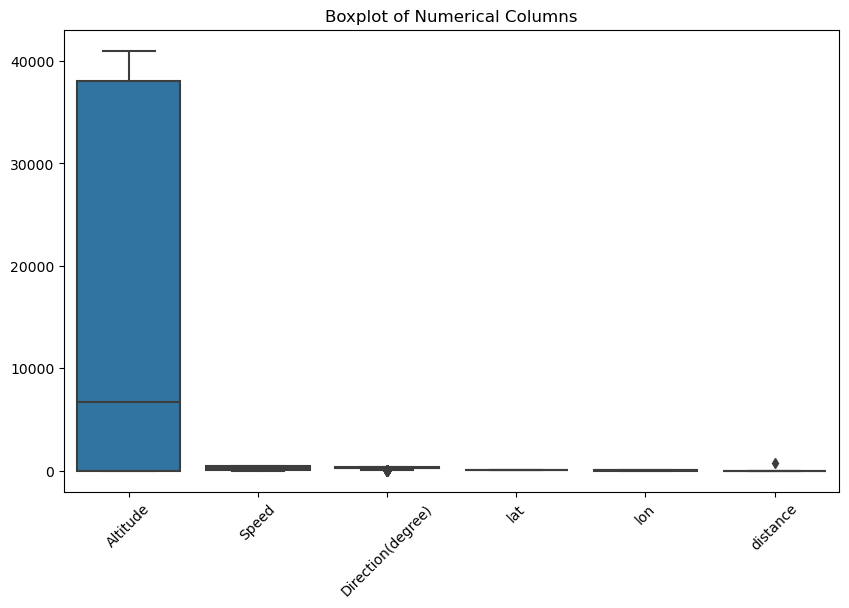

In [14]:
# using box plot to visualize the numerical column for outlier
numerical_columns = ['Altitude', 'Speed', 'Direction(degree)', 'lat', 'lon','distance']

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numerical_columns])
plt.title('Boxplot of Numerical Columns')
plt.xticks(rotation=45)
plt.show()


from this boxplot the altitude, speed, direction, and distance has outliers.

<Axes: xlabel='Speed'>

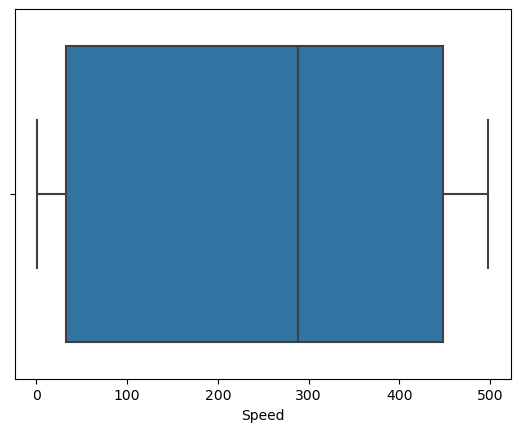

In [15]:
# using the boxplot to check the distribtion of the data in the speed columns
sns.boxplot(data = df, x='Speed')

C:\Users\dss\Desktop\Nkechi\ana\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


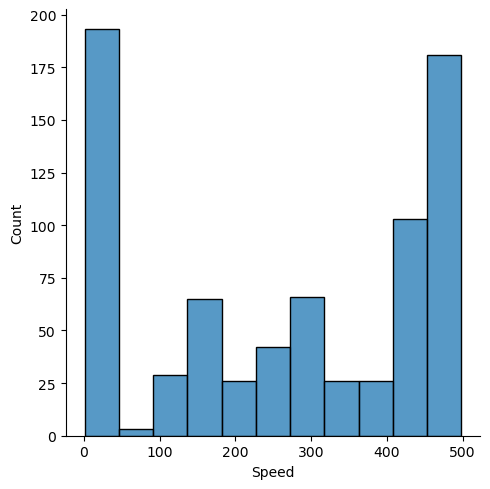

In [16]:
# histoplot to check the distribution of speed column
sns.displot(data = df, x='Speed')

C:\Users\dss\Desktop\Nkechi\ana\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


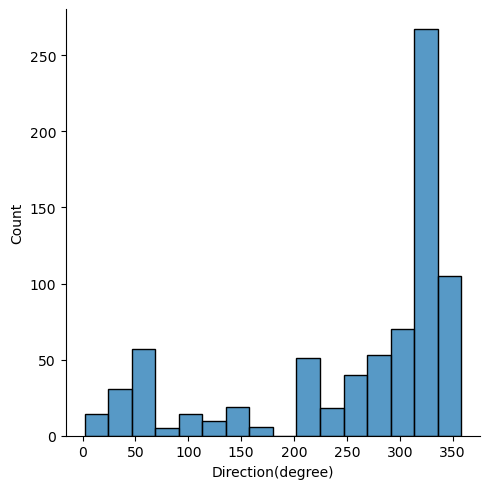

In [17]:
# histoplot to check the distribution of speed column
sns.displot(data = df, x='Direction(degree)')

<Axes: xlabel='Direction(degree)'>

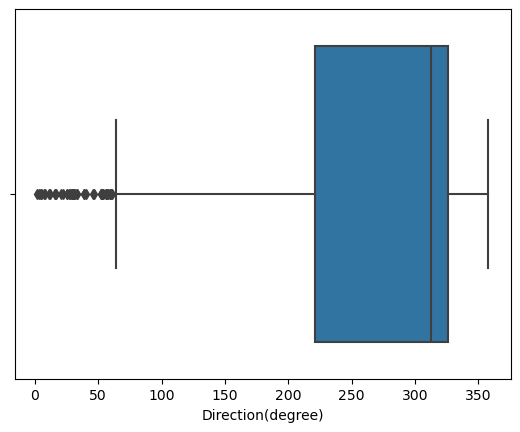

In [18]:
#boxplot to show the outlier in direction column
sns.boxplot(data = df, x ='Direction(degree)')

The boxplot show that outliers at the top the whisker suggest most of the outliers are below the mean while majority of the datapoint in the third quantile.

In [19]:
# checking for outliers that falls far from the mean using zscore
df['Direction_zscore'] = (df['Direction(degree)'] - df['Direction(degree)'].mean()) / df['Direction(degree)'].std()
df.head(10)


UTC  Altitude  Speed  Direction(degree)        lat  \
1  2023-01-09 22:43:25+00:00         0      3                 39  25.267582   
2  2023-01-09 22:43:45+00:00         0      3                 53  25.267376   
3  2023-01-09 22:44:07+00:00         0      1                 47  25.267284   
4  2023-01-09 22:44:41+00:00         0      1                354  25.267159   
5  2023-01-09 22:45:07+00:00         0      1                334  25.266953   
6  2023-01-09 22:48:35+00:00         0      3                334  25.267181   
7  2023-01-09 22:48:47+00:00         0      4                334  25.267399   
8  2023-01-09 22:48:57+00:00         0      5                334  25.267612   
9  2023-01-09 22:49:05+00:00         0      6                334  25.267822   
10 2023-01-09 22:49:13+00:00         0      7                337  25.268055   

          lon              Timestamp_UTC  distance cardinal_direction  \
1   51.605137 2023-01-09 00:00:01.673304  0.033274         North_East   
2   51.604946 2023-01-09 00:00:01.673304  0.029893         North_East   
3   51.604740 2023-01-09 00:00:01.673304  0.023103         North_East   
4   51.604538 2023-01-09 00:00:01.673304  0.024613              North   
5   51.604527 2023-01-09 00:00:01.673304  0.022933         North_West   
6   51.604412 2023-01-09 00:00:01.673304  0.027865         North_West   
7   51.604321 2023-01-09 00:00:01.673304  0.025910         North_West   
8   51.604210 2023-01-09 00:00:01.673304  0.026183         North_West   
9   51.604118 2023-01-09 00:00:01.673304  0.025117         North_West   
10  51.604027 2023-01-09 00:00:01.673304  0.027477         North_West   

    Direction_zscore  
1          -2.167579  
2          -2.029437  
3          -2.088641  
4           0.940610  
5           0.743265  
6           0.743265  
7           0.743265  
8           0.743265  
9           0.743265  
10          0.772867

In [20]:
#checking for the zscore below the mean
direction_below_mean =df[df['Direction_zscore']<-2]
direction_below_mean 

UTC  Altitude  Speed  Direction(degree)        lat  \
1   2023-01-09 22:43:25+00:00         0      3                 39  25.267582   
2   2023-01-09 22:43:45+00:00         0      3                 53  25.267376   
3   2023-01-09 22:44:07+00:00         0      1                 47  25.267284   
22  2023-01-09 22:50:28+00:00         0      9                 39  25.270981   
62  2023-01-09 22:54:27+00:00         0      8                 33  25.275700   
63  2023-01-09 22:54:34+00:00         0      8                  5  25.275932   
93  2023-01-09 22:58:08+00:00         0      8                 33  25.288992   
150 2023-01-09 23:02:19+00:00      3950    276                 54  25.198029   
151 2023-01-09 23:02:22+00:00      4000    282                 52  25.200682   
152 2023-01-09 23:02:25+00:00      4075    286                 53  25.203102   
153 2023-01-09 23:02:28+00:00      4100    289                 54  25.205338   
158 2023-01-09 23:02:46+00:00      4350    302                 52  25.217953   
159 2023-01-09 23:02:49+00:00      4375    304                 46  25.221680   
160 2023-01-09 23:02:52+00:00      4400    305                 40  25.224426   
161 2023-01-09 23:02:55+00:00      4450    306                 32  25.228287   
162 2023-01-09 23:02:58+00:00      4500    306                 28  25.232058   
163 2023-01-09 23:03:01+00:00      4550    306                 21  25.235825   
164 2023-01-09 23:03:05+00:00      4600    306                 17  25.239853   
165 2023-01-09 23:03:08+00:00      4650    306                 12  25.244114   
166 2023-01-09 23:03:11+00:00      4700    304                  7  25.248304   
167 2023-01-09 23:03:14+00:00      4750    303                  3  25.252945   
705 2023-01-10 05:03:59+00:00         0     10                 16  55.612873   
706 2023-01-10 05:04:04+00:00         0     11                 28  55.613071   
707 2023-01-10 05:04:08+00:00         0     11                 28  55.613258   
708 2023-01-10 05:04:12+00:00         0     12                 30  55.613457   
709 2023-01-10 05:04:16+00:00         0     13                 30  55.613640   
710 2023-01-10 05:04:22+00:00         0     14                 30  55.613972   
711 2023-01-10 05:04:28+00:00         0     15                 30  55.614315   
712 2023-01-10 05:04:34+00:00         0     15                 30  55.614658   
713 2023-01-10 05:04:40+00:00         0     16                 30  55.615036   
714 2023-01-10 05:04:46+00:00         0     17                 28  55.615471   
715 2023-01-10 05:04:52+00:00         0     18                 30  55.615871   
716 2023-01-10 05:04:57+00:00         0     16                 30  55.616215   
717 2023-01-10 05:05:04+00:00         0     10                 30  55.616516   
718 2023-01-10 05:05:10+00:00         0     10                 25  55.616749   
719 2023-01-10 05:05:14+00:00         0     10                 11  55.616982   
729 2023-01-10 05:06:03+00:00         0     11                  5  55.619682   
730 2023-01-10 05:06:08+00:00         0     12                 16  55.619934   
731 2023-01-10 05:06:12+00:00         0     13                 25  55.620140   
732 2023-01-10 05:06:15+00:00         0     13                 28  55.620323   
733 2023-01-10 05:06:20+00:00         0     14                 30  55.620552   
734 2023-01-10 05:06:24+00:00         0     14                 30  55.620781   
735 2023-01-10 05:06:27+00:00         0     15                 30  55.620964   
736 2023-01-10 05:06:33+00:00         0     15                 30  55.621323   
737 2023-01-10 05:06:39+00:00         0     11                 30  55.621593   
738 2023-01-10 05:06:45+00:00         0     10                 30  55.621822   
739 2023-01-10 05:06:51+00:00         0     11                 30  55.622051   
740 2023-01-10 05:06:56+00:00         0     10                 22  55.622288   
741 2023-01-10 05:07:01+00:00         0     11                  5  55.622509   
753 2023-01-10 05:08:21+00

In [21]:
direction_below_mean['cardinal_direction'].unique()

array(['North_East', 'North'], dtype=object)

This shows the outlier from north and north-east cardinal direction of the flight this is a contextual outlier because north signify the start point of the flight with respect to altitude and Direction(degree) vise-versa for north-east. 

In [22]:
# checking outlier above the mean using zscore
direction_below_mean =df[df['Direction_zscore']>2]
direction_below_mean 

Empty DataFrame
Columns: [UTC, Altitude, Speed, Direction(degree), lat, lon, Timestamp_UTC, distance, cardinal_direction, Direction_zscore]
Index: []

this shows no outlier was above the mean value

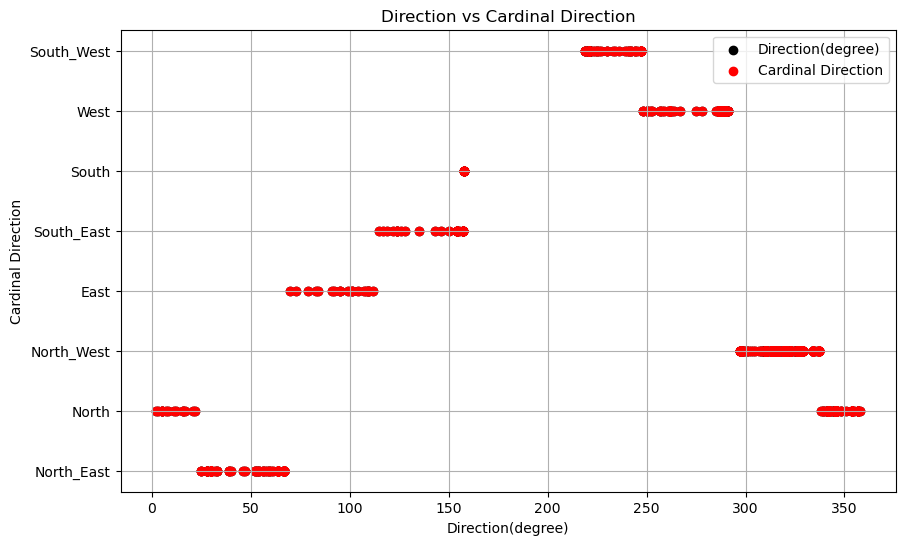

In [23]:
#visualizing the direction and cardinal direction columns
plt.figure(figsize=(10, 6))
plt.scatter(df['Direction(degree)'], df['cardinal_direction'], color='black', label='Direction(degree)')
plt.scatter(df['Direction(degree)'], df['cardinal_direction'], color='red', label='Cardinal Direction')
plt.xlabel('Direction(degree)')
plt.ylabel('Cardinal Direction')
plt.title('Direction vs Cardinal Direction')
plt.legend()
plt.grid(True)
plt.show()

Observing the Acceleration and Deacceleration of this flight using scatterplot shows that the ouliers in Direction column with respect to the cardinal direction are contextual outliers. in flight direction is measured in degrees ranging from 0 - 360 degrees

<Axes: xlabel='distance'>

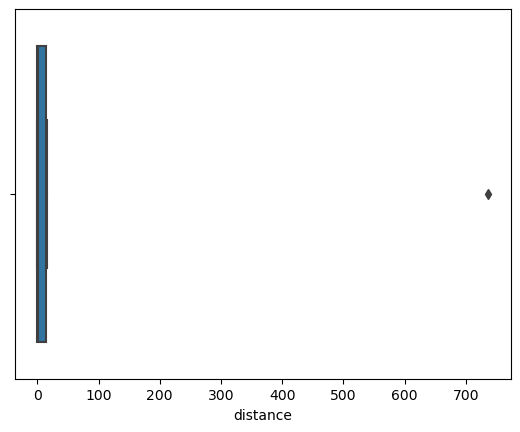

In [24]:
#visualizing the distance column for distance covered
sns.boxplot(data = df, x='distance')

This boxplot shows a distribution of distance, most of the data point are found in between zero and 14.0. this distribution also show an extreme outlier at 730

In [25]:
# open street map
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=5)

# Create a polyline for the flight path
flight_path = list(zip(df['lat'], df['lon']))
folium.PolyLine(locations=flight_path, color='blue', weight=2.5, opacity=1).add_to(m)

# Add timestamps as labels along the flight path
for i, row in df.iterrows(): 
    if i % 10 == 0:  # Add labels for every 10 data points
        iframe = IFrame(str(row['UTC']), width=150, height=40)
        folium.Marker(location=(row['lat'], row['lon']), popup=folium.Popup(iframe)).add_to(m)

# Save the map as an HTML file
map_path = 'flight_path_map.html'
m.save(map_path)

# Display the map using IPython's display function
from IPython.display import IFrame, HTML
display(HTML(f'<iframe src="{map_path}" width="100%" height="500"></iframe>'))


C:\Users\dss\AppData\Roaming\Python\Python311\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


This visualization, utilizing geographical data from OpenStreetMap, depicts the primary flight path from Qatar's Doha Airport to Ordu, Turkey, continuing on to Denmark's Kebenhavns Airport. The depicted flight route spans from January 9, 2023, at 11:01:49 PM UTC to January 10, 2023, at 05:03:34 AM UTC, totaling approximately 6 hours and 1 minute. Notably, the map visualization does not display an airport route at Ordu, Turkey, suggesting a direct flight without a layover. To address these disparities, further exploration of the distance column.

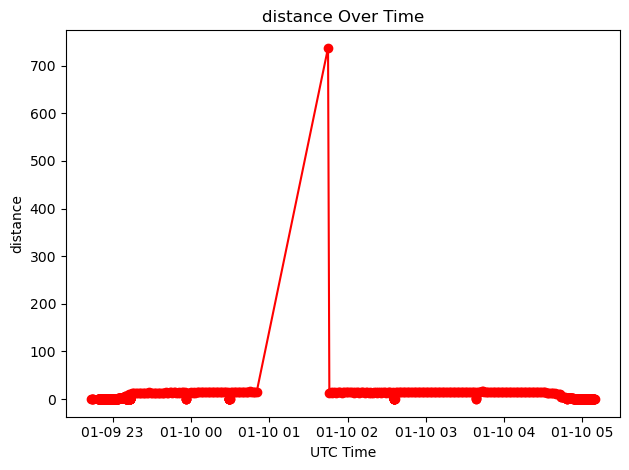

In [26]:
# Time series plot for distance
plt.plot(df['UTC'], df['distance'], marker='o', color='r')
plt.title('distance Over Time')
plt.xlabel('UTC Time')
plt.ylabel('distance')

plt.tight_layout()
plt.show()


Using the timeseries plot to detect the outlier in the distance column. It's highly unlikely for a distance to change from 50 to 736 units and then back to 50  within a span of one hour each during a flight. Such rapid and extreme changes in distance within such a short time frame would typically not occur in normal flight conditions, the one hour span does not suggest layover. Observing such drastic changes in distance within a short period during a flight, it might indicate errors in measurement, data interpretation, or some other anomaly rather than a realistic representation of the flight's progress. suggesting the distance of 736 might pass for an outlier.

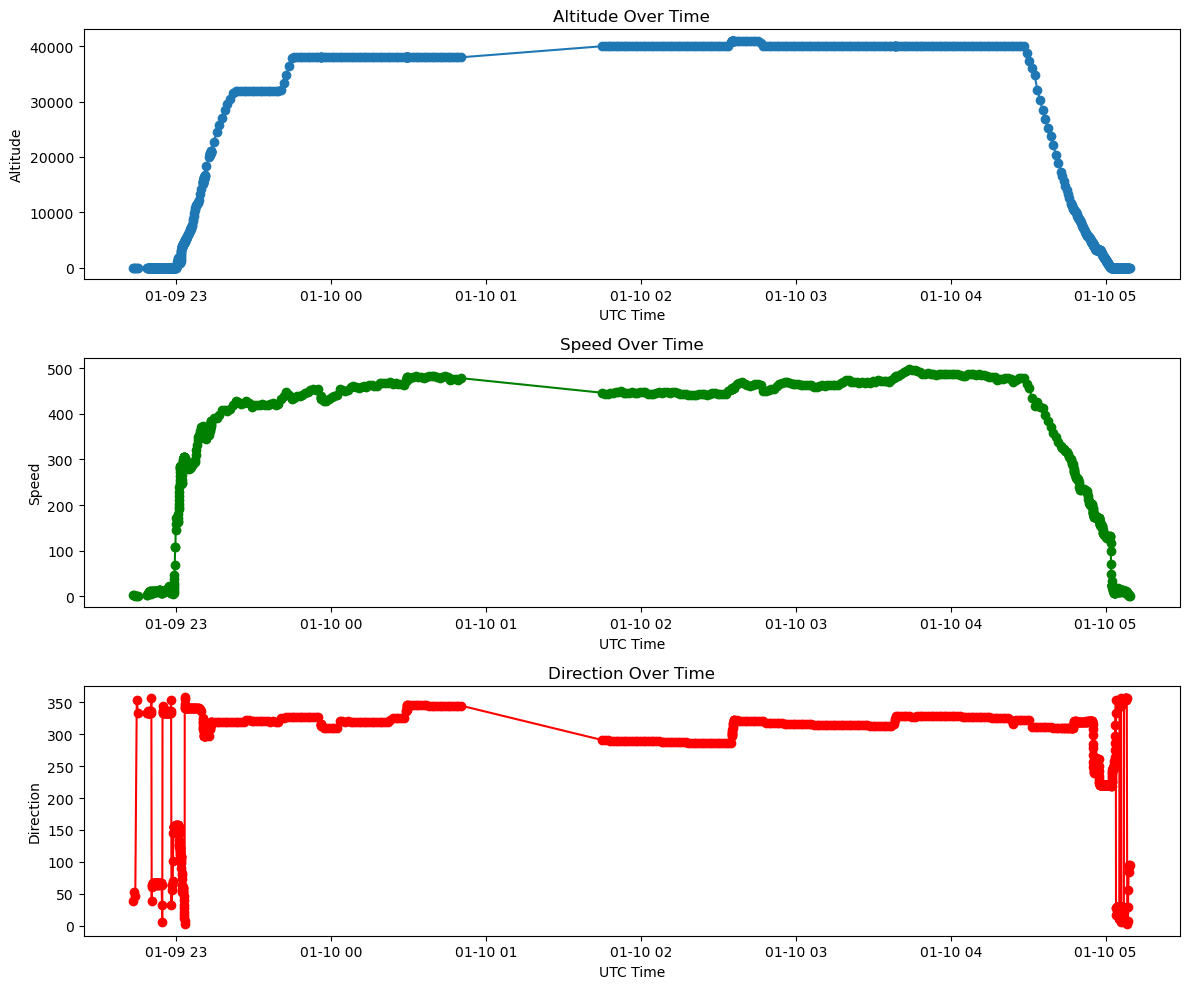

In [27]:
#Correlation Analysis
plt.figure(figsize=(12, 10))

# Time series plot for Altitude
plt.subplot(3, 1, 1)
plt.plot(df['UTC'], df['Altitude'], marker='o')
plt.title('Altitude Over Time')
plt.xlabel('UTC Time')
plt.ylabel('Altitude')

# Time series plot for Speed
plt.subplot(3, 1, 2)
plt.plot(df['UTC'], df['Speed'], marker='o', color='g')
plt.title('Speed Over Time')
plt.xlabel('UTC Time')
plt.ylabel('Speed')

# Time series plot for Direction
plt.subplot(3, 1, 3)
plt.plot(df['UTC'], df['Direction(degree)'], marker='o', color='r')
plt.title('Direction Over Time')
plt.xlabel('UTC Time')
plt.ylabel('Direction')

plt.tight_layout()
plt.show()


this time series plot shows that the data is interpolated or smoothed to fill in missing data points, this could have led to lead to inaccuracies in distance, Direction, altitude and speed with respect to time that occurred between 01.10-01 and  01.10-02.

<Axes: xlabel='distance'>

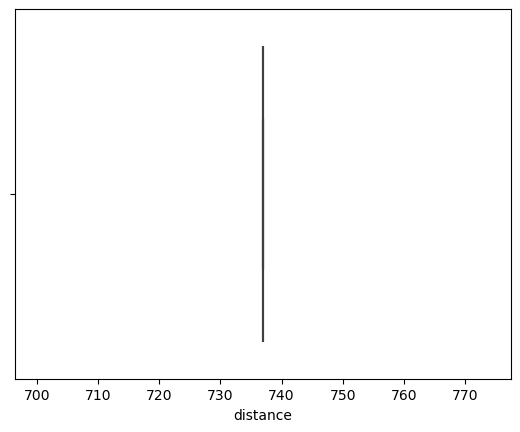

In [28]:
# isolating the outlier in the distance column
df_distance=df[df['distance']>600]
sns.boxplot(data = df_distance, x= 'distance')               

In [29]:
# subsetting to eliminate outlier from distance
df1=df[(df['distance']<736)]
df1

UTC  Altitude  Speed  Direction(degree)        lat  \
1   2023-01-09 22:43:25+00:00         0      3                 39  25.267582   
2   2023-01-09 22:43:45+00:00         0      3                 53  25.267376   
3   2023-01-09 22:44:07+00:00         0      1                 47  25.267284   
4   2023-01-09 22:44:41+00:00         0      1                354  25.267159   
5   2023-01-09 22:45:07+00:00         0      1                334  25.266953   
..                        ...       ...    ...                ...        ...   
756 2023-01-10 05:08:44+00:00         0      4                 56  55.626663   
757 2023-01-10 05:08:53+00:00         0      3                 84  55.626629   
758 2023-01-10 05:09:00+00:00         0      3                 92  55.626606   
759 2023-01-10 05:09:12+00:00         0      2                 95  55.626583   
760 2023-01-10 05:09:28+00:00         0      1                 95  55.626560   

           lon              Timestamp_UTC  distance cardinal_direction  \
1    51.605137 2023-01-09 00:00:01.673304  0.033274         North_East   
2    51.604946 2023-01-09 00:00:01.673304  0.029893         North_East   
3    51.604740 2023-01-09 00:00:01.673304  0.023103         North_East   
4    51.604538 2023-01-09 00:00:01.673304  0.024613              North   
5    51.604527 2023-01-09 00:00:01.673304  0.022933         North_West   
..         ...                        ...       ...                ...   
756  12.648260 2023-01-10 00:00:01.673327  0.014024         North_East   
757  12.648510 2023-01-10 00:00:01.673327  0.016144               East   
758  12.648718 2023-01-10 00:00:01.673327  0.013306               East   
759  12.648933 2023-01-10 00:00:01.673327  0.013738               East   
760  12.649155 2023-01-10 00:00:01.673327  0.014170               East   

     Direction_zscore  
1           -2.167579  
2           -2.029437  
3           -2.088641  
4            0.940610  
5            0.743265  
..                ...  
756         -1.999836  
757         -1.723552  
758         -1.644614  
759         -1.615012  
760         -1.615012  

[759 rows x 10 columns]

<Axes: xlabel='distance'>

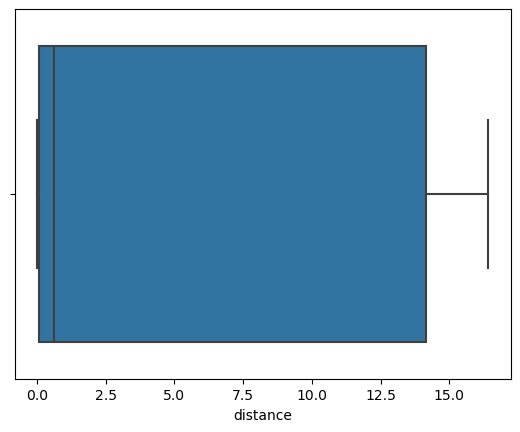

In [30]:
# dropping the outlier row
df_distance=df[df['distance']<736]
sns.boxplot(data = df_distance, x= 'distance')               
               

In [31]:
m = folium.Map(location=[df1['lat'].mean(), df1['lon'].mean()], zoom_start=5)

# Create a polyline for the flight path
flight_path = list(zip(df1['lat'], df1['lon']))
folium.PolyLine(locations=flight_path, color='blue', weight=2.5, opacity=1).add_to(m)

# Add timestamps as labels along the flight path
for i, row in df1.iterrows(): 
    if i % 10 == 0:  # Add labels for every 10 data points
        iframe = IFrame(str(row['UTC']), width=150, height=40)
        folium.Marker(location=(row['lat'], row['lon']), popup=folium.Popup(iframe)).add_to(m)

# Save the map as an HTML file
map_path = 'flight_path_map.html'
m.save(map_path)

# Display the map using IPython's display function
from IPython.display import IFrame, HTML
display(HTML(f'<iframe src="{map_path}" width="100%" height="500"></iframe>'))

C:\Users\dss\AppData\Roaming\Python\Python311\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


using the open street map to analysis the data point suggest the flight start point is hamad international airport, departure time of January 9, 2023, at 11:01:49 PM and arrival time January 10, 2023, at 05:03:34 AM at Denmark Copenhagen Airport in Københavns Lufthavn. The total duration of the flight appears to be approximately 6 hours and 1 minute which is the average time taken to get to Denmark from Doha.

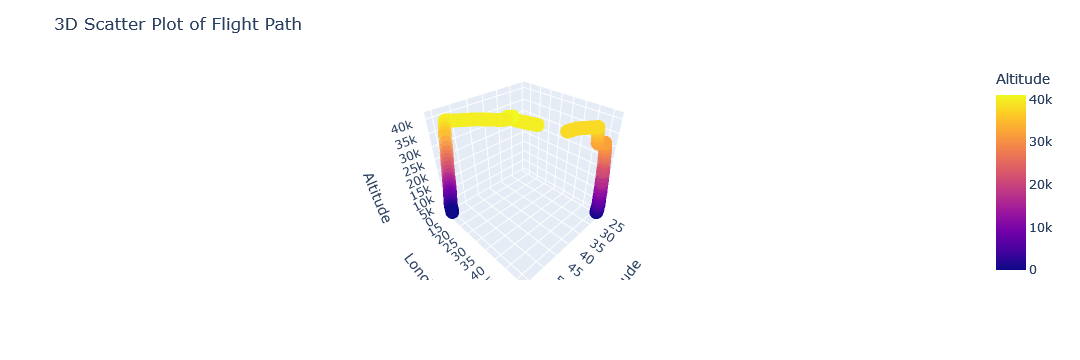

In [32]:
import plotly.express as px
#visualizing your data with 3D using plotly express

fig = px.scatter_3d(df,x ='lat', y ='lon', z= 'Altitude', color='Altitude', opacity=0.7)
fig.update_layout(title='3D Scatter Plot of Flight Path',
                  scene=dict(xaxis_title='Latitude', yaxis_title='Longitude', zaxis_title='Altitude'))
fig.show()


The 3D scatter plot offers a comprehensive view of the aircraft's spatial movements and altitude dynamics. The x-axis represents latitude, the y-axis represents longitude, and the z-axis represents altitude. Each data point in the plot corresponds to a specific geographic location and altitude during the flight.

In [33]:
non_numeric_columns = df1.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:", non_numeric_columns)


Non-numeric columns: Index(['cardinal_direction'], dtype='object')


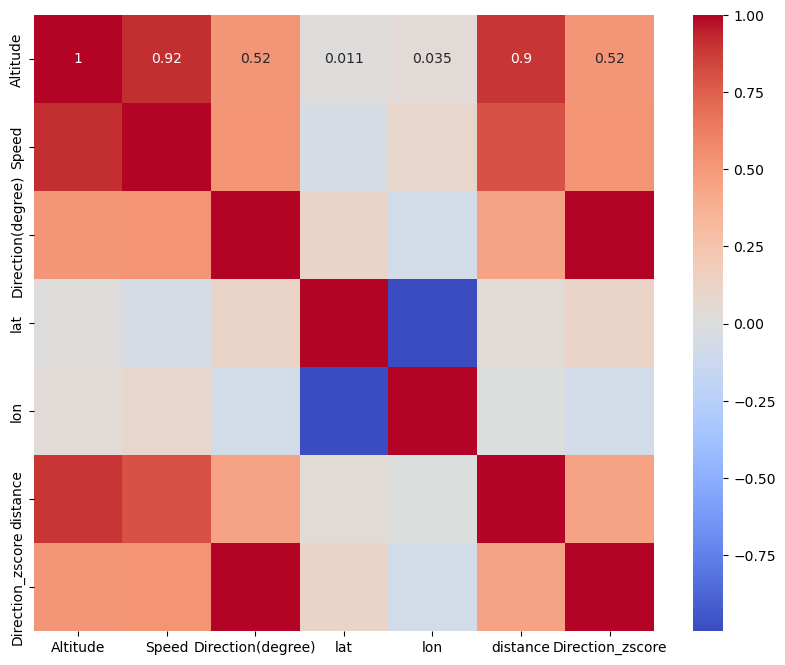

In [34]:
df1_numeric = df1.select_dtypes(include=[np.number])
corr = df1_numeric.corr()

# Create a heatmap for the numeric columns in df1
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


Altitude and speed have a strong positive correlation of 0.919. This indicates that as speed increases, Altitude tends to increase as well. 

## Regression

split / feature Engineering

In [35]:
# feature selection and Splitting of data into features (X) and target variable (y)
X = df[['Altitude', 'Direction(degree)', 'distance']]
y = df['Speed']

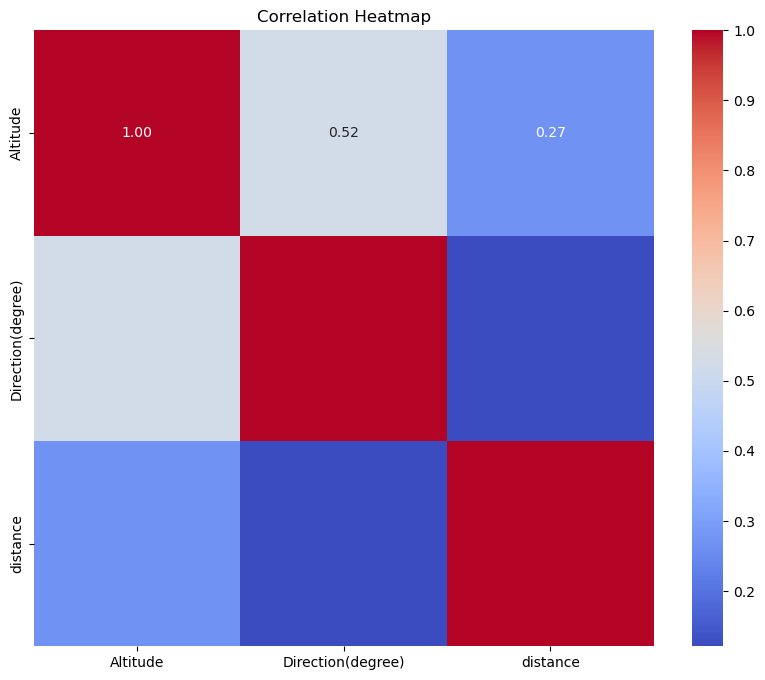

In [36]:
corr = X.corr()

# Create a heatmap for feature 
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap')
plt.show()

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
#calculating y mean for evalution
y_mean = y_train.mean()

In [39]:
# Calculate the baseline mean absolute error for your model.
y_pred_baseline =[y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean for alttitude:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean for alttitude: 266.77
Baseline MAE: 161.58


In [40]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [41]:
#Calculate the training and test mean absolute error for the model.
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 56.54
Test MAE: 54.75


this show the model perform better in the training set but do not generalize well on the test set. lets use a scatter plot to show that.

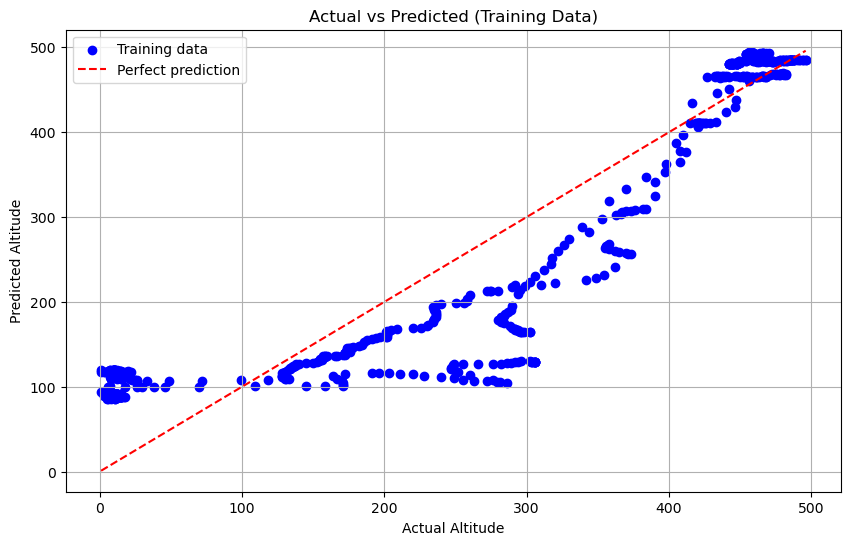

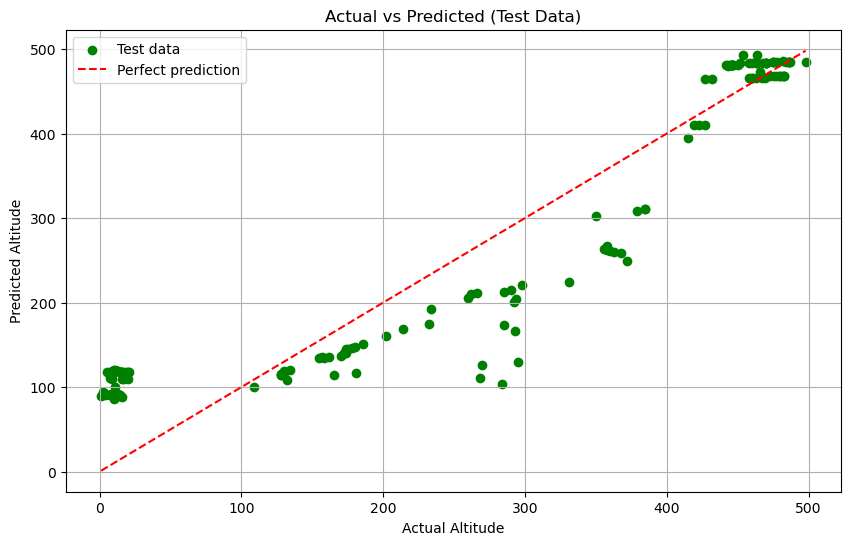

In [42]:
# Scatter plot for training data
plt.figure(figsize=(10, 6))
plt.scatter(y_train, model.predict(X_train), color='blue', label='Training data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', color='red', label='Perfect prediction')
plt.title('Actual vs Predicted (Training Data)')
plt.xlabel('Actual Altitude')
plt.ylabel('Predicted Altitude')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot for test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, model.predict(X_test), color='green', label='Test data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Perfect prediction')
plt.title('Actual vs Predicted (Test Data)')
plt.xlabel('Actual Altitude')
plt.ylabel('Predicted Altitude')
plt.legend()
plt.grid(True)
plt.show()

## Using RandomForestRegressor

In [43]:
# Define the steps in your pipeline
steps = [
    ('scaler', StandardScaler()),  # scale the features
    ('regressor', RandomForestRegressor()) 
]

# Create the pipeline
pipeline = Pipeline(steps)
# fit pipeline model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor())])

In [44]:
# Make predictions with model
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

In [45]:
# Evaluate model performance
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Training MAE:", train_mae)
print("Test MAE:", test_mae)

Training MAE: 1.541397752192983
Test MAE: 3.302542763157892


In [46]:

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", train_mse)
print("Test MSE:", test_mse)

Training MSE: 6.458789532300806
Test MSE: 25.855842514802625


use gridsearchCV for best parameter turing

In [47]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to search
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20],
    # Add other hyperparameters as needed
}

# Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'regressor__max_depth': 20, 'regressor__n_estimators': 100}


In [48]:
# using the best parameter for tunning the model after iterating

best_regressor = RandomForestRegressor(n_estimators=200, max_depth=10)  # Use the best parameters
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', best_regressor)
])

# Retrain the model on the entire training dataset
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=10, n_estimators=200))])

In [49]:
# Calculate MAE and MSE for training set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate MAE and MSE for test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training MAE:", round(train_mae, 2))
print("Test MAE:", round(test_mae, 2))
print("Training MSE:", round(train_mse, 2))
print("Test MSE:", round(test_mse, 2))

Training MAE: 1.54
Test MAE: 3.3
Training MSE: 6.46
Test MSE: 25.86


The RandomForestRegressor model perform even better in the test set more than the training making it a better model for the training set than linearRegressor. lets use the scatterplot to visual this.

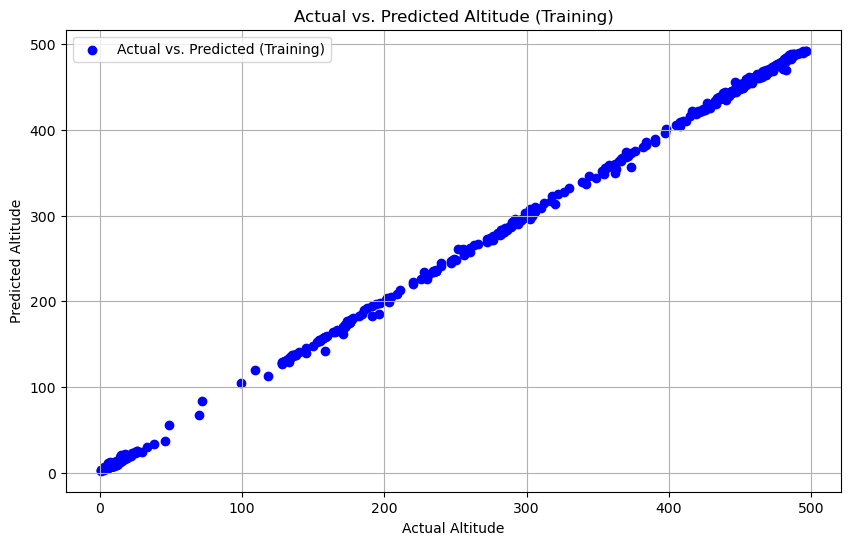

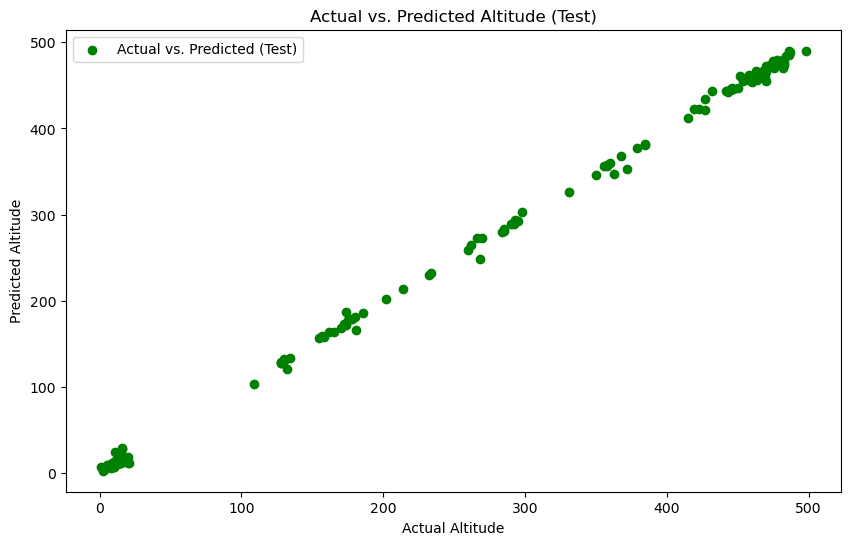

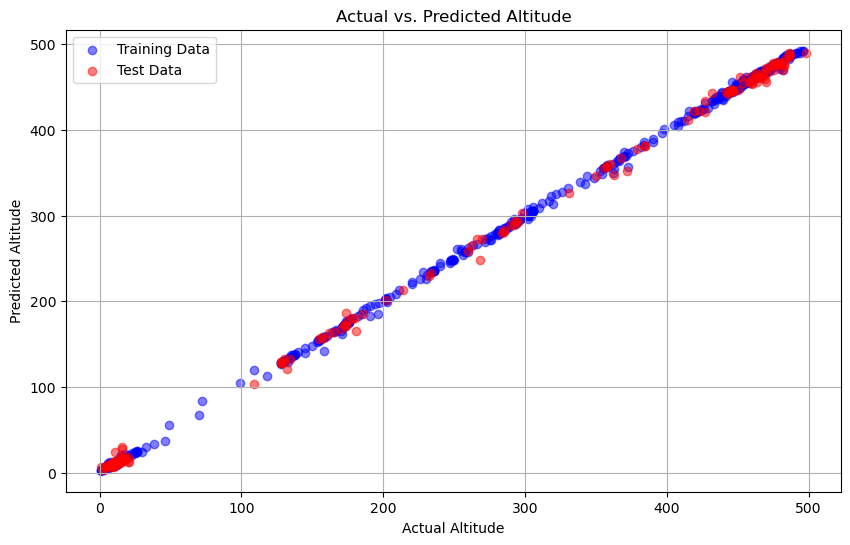

In [50]:
# Plotting the actual vs. predicted values for the training set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Actual vs. Predicted (Training)')
plt.xlabel('Actual Altitude')
plt.ylabel('Predicted Altitude')
plt.title('Actual vs. Predicted Altitude (Training)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the actual vs. predicted values for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='green', label='Actual vs. Predicted (Test)')
plt.xlabel('Actual Altitude')
plt.ylabel('Predicted Altitude')
plt.title('Actual vs. Predicted Altitude (Test)')
plt.legend()

# Plotting the actual vs. predicted values for the training set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label='Training Data')
plt.scatter(y_test, y_test_pred, color='red', alpha=0.5, label='Test Data')
plt.xlabel('Actual Altitude')
plt.ylabel('Predicted Altitude')
plt.title('Actual vs. Predicted Altitude')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
from sklearn.model_selection import cross_val_score
# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross-Validation Scores: [-4.01849506 -4.11498808 -5.24565348 -4.8018607  -4.5583574 ]
Mean CV Score: -4.547870945207977


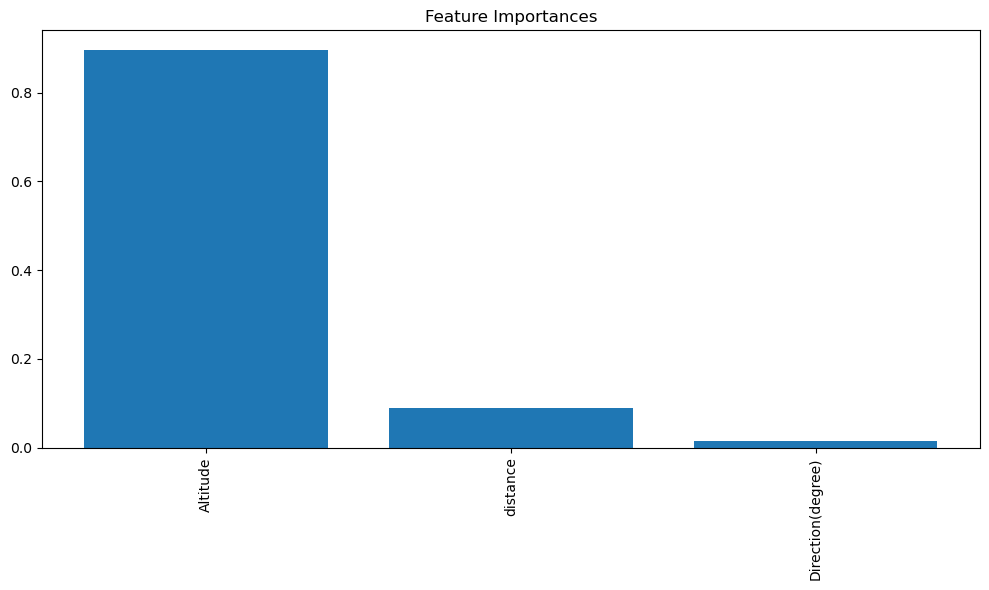

In [52]:
# Access feature importances
feature_importances = pipeline.named_steps['regressor'].feature_importances_


# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

This show  that Altitude is the most important feature that contribute to the change in speed  it contribute over 80%

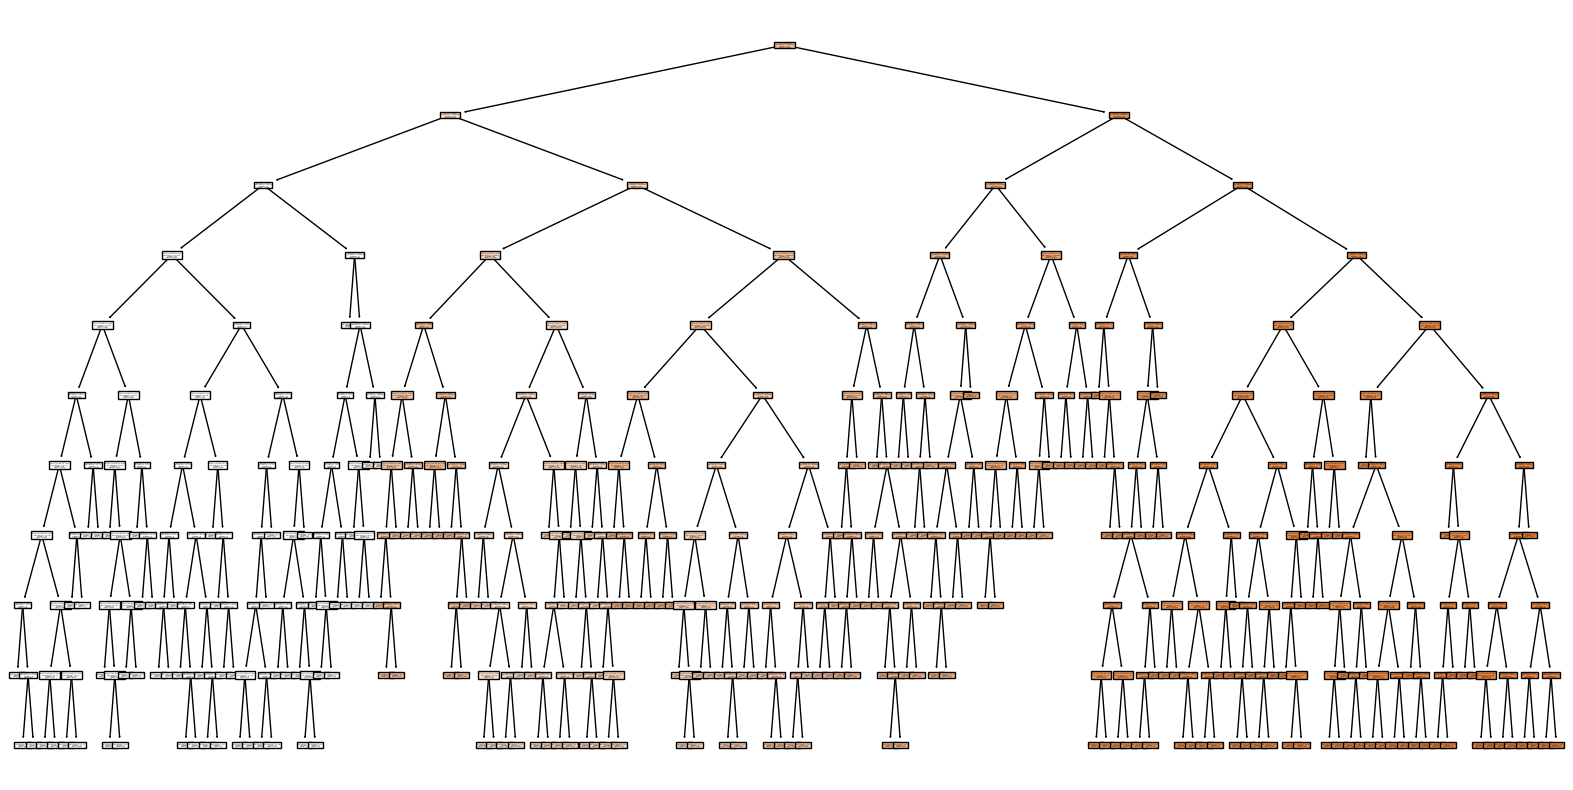

In [53]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(pipeline.named_steps['regressor'].estimators_[0], feature_names=X_train.columns, filled=True)
plt.show()

## RECOMMENDATION

## Flight Route Optimization

Investigate Outlier Causes: Explore the reasons behind outlier data points, especially those suggesting significant deviations in flight paths or unusual durations. This could involve looking into air traffic control instructions, weather patterns, or technical issues that may have led to non-standard routing.

Optimize Flight Paths: Using accurate geographic data, optimize flight routes to minimize travel time and fuel consumption. This can be achieved through better route planning and real-time adjustments based on traffic and weather conditions.

### Enhanced Monitoring and Reporting

Implement Advanced Analytics: Use predictive analytics to anticipate potential issues or deviations in flight paths and schedules. This can involve real-time tracking and reporting systems that provide insights into flights' status and any deviations from expected behavior.

Dashboard Integration: Develop comprehensive dashboards that integrate key metrics such as altitude, speed, and direction. Visualize these metrics using scatter plots, time series, and 3D scatter plots to facilitate better monitoring and decision-making.

### Operational Efficiency and Safety

Improve Altitude and Speed Management: The strong correlation between altitude and speed suggests that precise management of these parameters can improve flight efficiency. Implement systems to monitor and optimize these variables dynamically during flights.

Safety Protocols: Outliers in altitude and speed can indicate safety risks. Establish protocols for immediate action when abnormal values are detected, including communication with pilots and adjustments to flight operations.

Customer Communication: Enhance communication with passengers by providing accurate information about flight durations, potential delays, and expected arrival times. Transparency helps build trust and improves the overall customer experience.

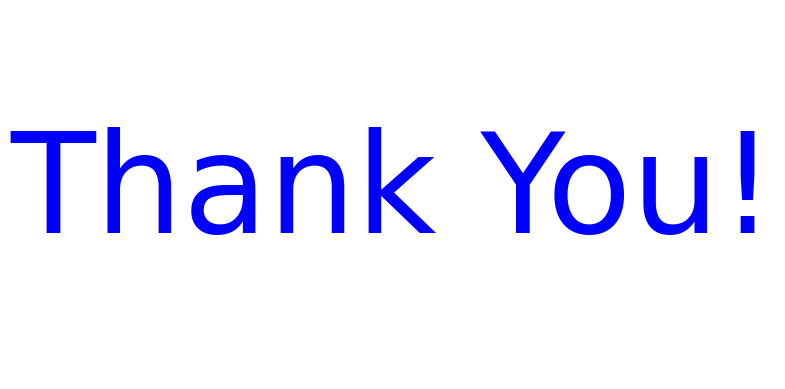

In [63]:
plt.text(0.5, 0.5, 'Thank You!', horizontalalignment='center', verticalalignment='center', fontsize=100, color = 'blue')
plt.axis('off')
plt.show()
